# Single Cell Analysis - HCT116 Spheroids

## Setup

In [3]:
import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re

# Configuration
PIXEL_SIZE_UM = 0.227
Z_STEP_UM = 5.0
DATA_PATH = "/home/jovyan/share/data/analyses/christa/colopaint3D/spher_colo52_v1/1_Data/FeaturesImages_291025_none/SingleCell/HCT116.parquet"

os.getcwd()

'/share/data/analyses/christa/colopaint3D/spher_colo52_v1/1_Data'

## Analysis Plan

**CONTEXT:** Technical artifact from imaging depth (z-plane) creates variation that overshadows biological variation from radial distance (spheroid outer→inner layers). In center z-planes, we can see radial biology within a single plane.

**PLAN A (full dataset):**
1. Make sure to keep track of metadata on the X,Y,Z location of each cell in the 3D image stack
   - Location_Center_X
   - Location_Center_Y
   - Location_Center_Z
   - Compute radial distance from spheroid center for each cell
2. Squeeze the metadata into the index of the dataframe
3. Harmony integration using z-plane as batch covariate to remove technical depth artifacts
   - Test on DMSO controls first to verify it reveals radial biology
4. Assign each cell to a cluster (Leiden clustering), just do it for a handful of dmso controls first
5. Check if clusters correspond to different layers of the 3D cell culture (radial distance from center)
6. Aggregate single cell data to spheroid layer level (mean or median feature values per layer)
7. Continue preprocessing and clustering at the spheroid layer level

**PLAN B (fallback if Harmony removes too much biology):**
Focus analysis only on central z-planes where technical and biological signals are less confounded. This avoids the confounding issue at top/bottom planes where radial distance ≈ z-plane position.

## Load Data

In [4]:
DataSingleCell = pd.read_parquet(DATA_PATH)
print(f"Loaded {DataSingleCell.shape[0]:,} cells with {DataSingleCell.shape[1]} columns")

Loaded 873,550 cells with 2167 columns


## Convert to AnnData Format

In [5]:
def convert_to_anndata(df, pixel_size=0.227, z_step=5.0):
    """
    Convert CellProfiler DataFrame to AnnData format.
    
    Args:
        df: DataFrame with single cell data (features + metadata)
        pixel_size: Pixel size in microns
        z_step: Z-step size in microns
    
    Returns:
        AnnData object with proper organization
    """
    
    # 1. Separate columns by type
    metadata_cols = [c for c in df.columns if c.startswith('Metadata_') or 
                     c.startswith('FileName_') or c.startswith('PathName_')]
    
    location_cols = [c for c in df.columns if 'Location_Center' in c]
    
    identifier_cols = [c for c in df.columns if c.startswith('ImageNumber_') or 
                      c.startswith('ObjectNumber_')]
    
    exclude_cols = metadata_cols + location_cols + identifier_cols
    feature_cols = [c for c in df.columns if c not in exclude_cols]
    
    print(f"Column breakdown:")
    print(f"  Metadata: {len(metadata_cols)}")
    print(f"  Location: {len(location_cols)}")
    print(f"  Identifiers: {len(identifier_cols)}")
    print(f"  Features: {len(feature_cols)}")
    
    # 2. Create the main feature matrix (X)
    X = df[feature_cols].values
    
    # 3. Create .obs (cell-level metadata)
    obs = df[metadata_cols + identifier_cols].copy()
    obs.index = obs.index.astype(str)
    
    # # 4. Create .var (feature-level metadata)
    # var = pd.DataFrame(index=feature_cols)
    
    # def parse_feature_name(name):
    #     parts = name.split('_')
    #     info = {
    #         'measurement_type': parts[0] if len(parts) > 0 else 'unknown',
    #         'compartment': parts[-1] if len(parts) > 0 else 'unknown',
    #         'channel': None,
    #         'metric': None
    #     }
        
    #     channels = ['HOECHST', 'MITO', 'SYTO', 'PHAandWGA', 'CONC']
    #     for channel in channels:
    #         if channel in name:
    #             info['channel'] = channel
    #             break
        
    #     if len(parts) > 1:
    #         info['metric'] = parts[1]
        
    #     return pd.Series(info)
    
    # var_info = pd.DataFrame([parse_feature_name(name) for name in feature_cols], index=feature_cols)
    # var = pd.concat([var, var_info], axis=1)
    
    # 5. Create .obsm (multi-dimensional annotations)
    obsm = {}
    
    if 'Location_Center_X_cytoplasm' in df.columns:
        spatial_2d = np.column_stack([
            df['Location_Center_X_cytoplasm'].values,
            df['Location_Center_Y_cytoplasm'].values
        ])
        obsm['spatial_2d'] = spatial_2d
    
    # 6. Create .uns (unstructured metadata)
    uns = {
        'pixel_size_um': pixel_size,
        'z_step_um': z_step,
        'dataset': 'HCT116',
    }
    
    # 7. Create AnnData object
    adata = ad.AnnData(X=X, obs=obs, obsm=obsm, uns=uns)
    
    print(f"\nAnnData object created:")
    print(f"  Shape: {adata.shape} (cells × features)")
    print(f"  .obs columns: {adata.obs.shape[1]}")
    print(f"  .var columns: {adata.var.shape[1]}")
    print(f"  .obsm keys: {list(adata.obsm.keys())}")
    print(f"  .uns keys: {list(adata.uns.keys())}")
    
    return adata

In [6]:
# Convert to AnnData
adata = convert_to_anndata(DataSingleCell, pixel_size=PIXEL_SIZE_UM, z_step=Z_STEP_UM)
del DataSingleCell  # Free memory
adata

Column breakdown:
  Metadata: 48
  Location: 23
  Identifiers: 5
  Features: 2091

AnnData object created:
  Shape: (873550, 2091) (cells × features)
  .obs columns: 53
  .var columns: 0
  .obsm keys: ['spatial_2d']
  .uns keys: ['pixel_size_um', 'z_step_um', 'dataset']


AnnData object with n_obs × n_vars = 873550 × 2091
    obs: 'Metadata_AcqID_cytoplasm', 'Metadata_Barcode', 'Metadata_Site', 'Metadata_Well', 'FileName_CONC_cytoplasm', 'FileName_HOECHST_cytoplasm', 'FileName_MITO_cytoplasm', 'FileName_PHAandWGA_cytoplasm', 'FileName_SYTO_cytoplasm', 'PathName_CONC_cytoplasm', 'PathName_HOECHST_cytoplasm', 'PathName_MITO_cytoplasm', 'PathName_PHAandWGA_cytoplasm', 'PathName_SYTO_cytoplasm', 'Metadata_AcqID_nuclei', 'FileName_CONC_nuclei', 'FileName_HOECHST_nuclei', 'FileName_MITO_nuclei', 'FileName_PHAandWGA_nuclei', 'FileName_SYTO_nuclei', 'PathName_CONC_nuclei', 'PathName_HOECHST_nuclei', 'PathName_MITO_nuclei', 'PathName_PHAandWGA_nuclei', 'PathName_SYTO_nuclei', 'Metadata_AcqID_cells', 'FileName_CONC_cells', 'FileName_HOECHST_cells', 'FileName_MITO_cells', 'FileName_PHAandWGA_cells', 'FileName_SYTO_cells', 'PathName_CONC_cells', 'PathName_HOECHST_cells', 'PathName_MITO_cells', 'PathName_PHAandWGA_cells', 'PathName_SYTO_cells', 'Metadata_image_id', 

## Add Spatial Metadata

In [7]:
def calc_radial_distance_3d(adata, pixel_size=0.227, z_step=5.0):
    """
    Calculate 3D radial distance from equatorial plane center for each cell.
    Operates on AnnData object and adds metadata to .obs.
    
    Args:
        adata: AnnData object with single cell data
        pixel_size: Pixel size in microns (default: 0.227 µm/pixel)
        z_step: Z-step size in microns (default: 5.0 µm)
    
    Returns:
        adata with added Metadata_Radial_Distance_3D and Metadata_Equatorial_Z columns
    """
    # Get location data from obsm
    xy_coords = adata.obsm['spatial_2d']
    
    # Create temporary DataFrame for calculations
    df = pd.DataFrame({
        'Location_Center_X_cytoplasm': xy_coords[:, 0],
        'Location_Center_Y_cytoplasm': xy_coords[:, 1],
        'Metadata_Z': adata.obs['Metadata_Z'].values,
        'Metadata_Spheroid_ID': adata.obs['Metadata_Spheroid_ID'].values
    })
    
    centers = []
    for sph_id, sph_data in df.groupby('Metadata_Spheroid_ID'):
        # Find equatorial plane (largest radial extent)
        max_radius, center_x, center_y, center_z = 0, None, None, None
        for z, z_data in sph_data.groupby('Metadata_Z'):
            cx = z_data['Location_Center_X_cytoplasm'].mean()
            cy = z_data['Location_Center_Y_cytoplasm'].mean()
            r_max = np.sqrt((z_data['Location_Center_X_cytoplasm'] - cx)**2 + 
                           (z_data['Location_Center_Y_cytoplasm'] - cy)**2).max()
            if r_max > max_radius:
                max_radius, center_x, center_y, center_z = r_max, cx, cy, z
        centers.append({'Metadata_Spheroid_ID': sph_id, 'Center_X': center_x, 
                       'Center_Y': center_y, 'Center_Z': center_z})
    
    # Merge centers and calculate 3D radial distance
    centers_df = pd.DataFrame(centers)
    df = df.merge(centers_df, on='Metadata_Spheroid_ID', how='left')
    
    # Convert to microns and calculate 3D distance
    x_um = (df['Location_Center_X_cytoplasm'] - df['Center_X']) * pixel_size
    y_um = (df['Location_Center_Y_cytoplasm'] - df['Center_Y']) * pixel_size
    z_um = (df['Metadata_Z'] - df['Center_Z']) * z_step
    
    radial_dist_3d = np.sqrt(x_um**2 + y_um**2 + z_um**2)
    
    # Add to adata.obs
    adata.obs['Metadata_Radial_Distance_3D'] = radial_dist_3d.values
    adata.obs['Metadata_Equatorial_Z'] = df['Center_Z'].values
    
    # Update spatial_3d in obsm to include Z coordinate
    spatial_3d = np.column_stack([
        xy_coords[:, 0],
        xy_coords[:, 1],
        adata.obs['Metadata_Z'].values
    ])
    adata.obsm['spatial_3d'] = spatial_3d
    
    # Store spheroid centers in .uns
    spheroid_centers = {}
    for _, row in centers_df.iterrows():
        spheroid_centers[row['Metadata_Spheroid_ID']] = {
            'center_x': row['Center_X'],
            'center_y': row['Center_Y'],
            'center_z': row['Center_Z']
        }
    adata.uns['spheroid_centers'] = spheroid_centers
    adata.uns['n_spheroids'] = len(spheroid_centers)
    adata.uns['n_z_planes'] = len(adata.obs['Metadata_Z'].unique())
    
    return adata

In [8]:
# Extract Z-plane from filename
adata.obs['Metadata_Z'] = adata.obs['FileName_CONC_cytoplasm'].str.extract(r'-z(\d+)-')[0].astype(int)

# Create spheroid ID
adata.obs['Metadata_Spheroid_ID'] = (
    adata.obs['Metadata_Barcode'].astype(str) + '_' + 
    adata.obs['Metadata_Well'].astype(str)
)

# Calculate 3D radial distance
adata = calc_radial_distance_3d(adata, pixel_size=PIXEL_SIZE_UM, z_step=Z_STEP_UM)

print(f"Added Metadata_Z, Metadata_Spheroid_ID, and Metadata_Radial_Distance_3D")
print(f"3D Radial distance range: {adata.obs['Metadata_Radial_Distance_3D'].min():.1f} - {adata.obs['Metadata_Radial_Distance_3D'].max():.1f} µm")
print(f"\nZ-planes: {sorted(adata.obs['Metadata_Z'].unique())}")
print(f"\nEquatorial Z-planes by spheroid:")
print(adata.obs.groupby('Metadata_Spheroid_ID')['Metadata_Equatorial_Z'].first().head())

Added Metadata_Z, Metadata_Spheroid_ID, and Metadata_Radial_Distance_3D
3D Radial distance range: 0.1 - 205.1 µm

Z-planes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Equatorial Z-planes by spheroid:
Metadata_Spheroid_ID
PB000137_B02     8
PB000137_B04    10
PB000137_B05    10
PB000137_B06    11
PB000137_B08    11
Name: Metadata_Equatorial_Z, dtype: int64


## Visualization

In [15]:
adata.obs['Metadata_Spheroid_ID'].unique()[2]

'PB000137_M11'

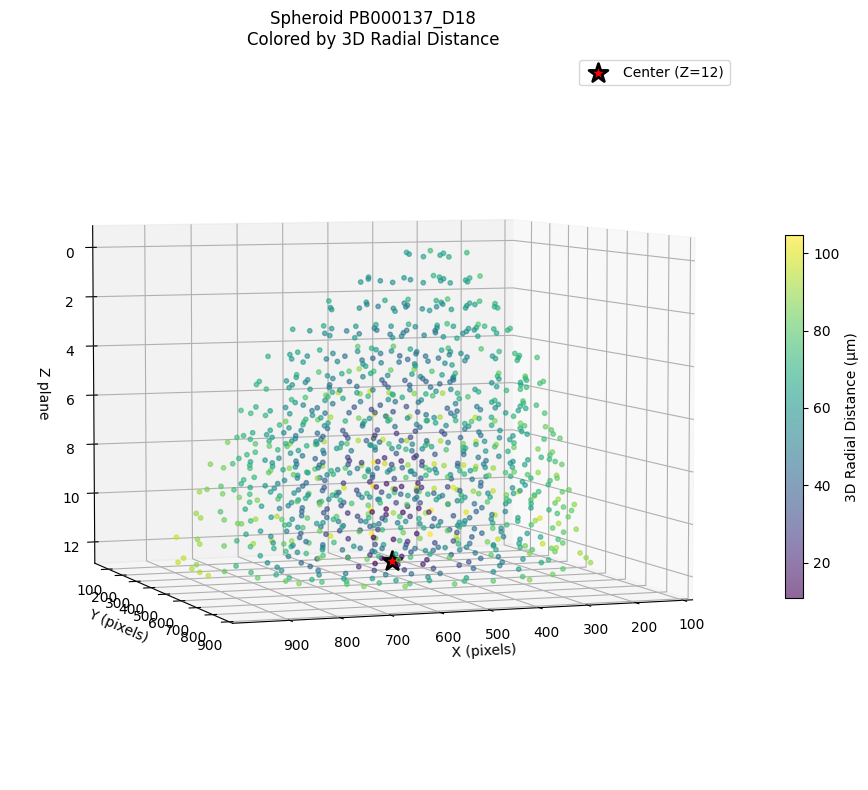

Equatorial plane: Z = 12
Center coordinates: X=543.4, Y=502.9, Z=12


In [32]:
# Visualize a sample spheroid in 3D colored by 3D radial distance
sample_sph = adata.obs['Metadata_Spheroid_ID'].unique()[6]
sample_mask = adata.obs['Metadata_Spheroid_ID'] == sample_sph
sample_data = adata[sample_mask]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get spatial coordinates and radial distance
xyz = sample_data.obsm['spatial_3d']
radial_dist = sample_data.obs['Metadata_Radial_Distance_3D'].values

# Plot all cells colored by radial distance
scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                     c=radial_dist, cmap='viridis', s=10, alpha=0.6)

# Get equatorial plane and center coordinates
eq_z = sample_data.obs['Metadata_Equatorial_Z'].iloc[0]
center_info = adata.uns['spheroid_centers'][sample_sph]
center_x = center_info['center_x']
center_y = center_info['center_y']

# Mark the center point
ax.scatter([center_x], [center_y], [eq_z], 
          c='red', s=200, marker='*', edgecolors='black', linewidths=2,
          label=f'Center (Z={eq_z})')

# Flip Z axis (plane 12 at bottom)
ax.invert_zaxis()

# Set viewing angle
ax.view_init(elev=5, azim=70)

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_zlabel('Z plane')
ax.set_title(f'Spheroid {sample_sph}\nColored by 3D Radial Distance')
ax.legend()
plt.colorbar(scatter, label='3D Radial Distance (µm)', shrink=0.5)
plt.tight_layout()
plt.show()

print(f"Equatorial plane: Z = {eq_z}")
print(f"Center coordinates: X={center_x:.1f}, Y={center_y:.1f}, Z={eq_z}")

## Sanity Checks

In [10]:
print("=== SANITY CHECKS ===\n")

# Check filtering by spheroid
print("1. Filter cells from one spheroid:")
spheroid_id = adata.obs['Metadata_Spheroid_ID'].iloc[0]
spheroid_cells = adata[adata.obs['Metadata_Spheroid_ID'] == spheroid_id]
print(f"   Spheroid {spheroid_id}: {spheroid_cells.n_obs} cells\n")

# Check spatial coordinates
print("2. Access 3D spatial coordinates:")
xyz = adata.obsm['spatial_3d']
print(f"   Shape: {xyz.shape}")
print(f"   X range: {xyz[:, 0].min():.1f} - {xyz[:, 0].max():.1f} pixels")
print(f"   Y range: {xyz[:, 1].min():.1f} - {xyz[:, 1].max():.1f} pixels")
print(f"   Z range: {xyz[:, 2].min():.0f} - {xyz[:, 2].max():.0f} planes\n")

# Check radial distance distribution
print("3. Radial distance distribution:")
rad_dist = adata.obs['Metadata_Radial_Distance_3D']
print(f"   Min: {rad_dist.min():.1f} µm")
print(f"   Median: {rad_dist.median():.1f} µm")
print(f"   Max: {rad_dist.max():.1f} µm\n")

# Check feature categories
print("4. Feature measurement types:")
print(adata.var['measurement_type'].value_counts())

=== SANITY CHECKS ===

1. Filter cells from one spheroid:
   Spheroid PB000137_E12: 549 cells

2. Access 3D spatial coordinates:
   Shape: (873550, 3)
   X range: 4.3 - 1017.6 pixels
   Y range: 6.2 - 1017.3 pixels
   Z range: 0 - 12 planes

3. Radial distance distribution:
   Min: 0.1 µm
   Median: 74.3 µm
   Max: 205.1 µm

4. Feature measurement types:


KeyError: 'measurement_type'